# Импорт библиотек

In [171]:
import json
import re

import pandas as pd

import matplotlib.pyplot as plt
from pandas import DataFrame

from wordcloud import WordCloud


# Объединим все данные в один датасет

In [172]:
def open_json(input_file: str) -> dict:
    with open(input_file) as json_file:
        data = json.load(json_file)
    return data

In [173]:
def json_to_csv_lp(json_data: dict) -> DataFrame:
    rows = []
    for category, works in json_data.items():
        for author, work_data in works.items():
            rows.append({
                "title": work_data.get("title", ""),
                "text": work_data.get("text", "")
            })

    df = pd.DataFrame(rows)
    return df

In [174]:
def json_to_csv(json_data: dict) -> DataFrame:
    rows = []
    for title, text in json_data.items():
        rows.append({
            "title": title,
            "text": text
        })

    df = pd.DataFrame(rows)
    return df

clean_data

In [175]:
briefly = open_json("../data/temp_data/json/briefly.json")
litprichal = open_json("../data/temp_data/json/data_litprichal.json")
proza_ru = open_json("../data/temp_data/json/data_proza_ru.json")
litres = open_json("../data/temp_data/json/litres.json")

In [176]:
briefly = json_to_csv(briefly)
litprichal = json_to_csv_lp(litprichal)
proza_ru = json_to_csv_lp(proza_ru)
litres = json_to_csv(litres)

In [177]:
data = pd.concat([briefly, litprichal, proza_ru, litres], ignore_index=True)

In [178]:
data

,title,text
0,"Житие протопопа Аввакума, им самим написанное",Протопоп Аввакум написал житие по благословени...
1,Переписка Андрея Курбского с Иваном Грозным,Князь Андрей Курбский — один из лучших воевод ...
2,Житие Сергия Радонежского,"Преподобный Сергий родился в Тверской земле, в..."
3,Повесть о Петре и Февронии Муромских,В городе Муроме правил князь Павел. К его жене...
4,Моление Даниила Заточника,"«Моление», как и многие другие произведения др..."
...,...,...
32787,Мифические монстры и места их обитания,В этой увлекательной и познавательной книге ав...
32788,Легенда о страшном Змее и наглой девице,Всё пошло не так: девица явилась сама в змеево...
32789,Сказки темной Руси,"Гуляли, значит, по матушке Руси три статных мо..."
32790,"Сезам, откройся!!!","«– Вы начинаете стареть, Иоганн, – ворчливо ск..."


In [179]:
len(briefly) + len(litprichal) + len(proza_ru) + len(litres) - len(data)

0

Никакие данные не потерялись

# Работа с данными

In [180]:
data = data.apply(lambda col: col.str.lower().str.strip())

## Почистим данные от всего лишнего

### Удалим лишние символы

Удалим пропущенные значения

In [181]:
data.isna().sum()

title      0
text     707
dtype: int64

In [182]:
data = data.dropna().reset_index(drop=True)

In [183]:
def clean_text(text):
    """Более аккуратная очистка текста для генерации заголовков"""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"<[^>]+>", "", text)
    text = re.sub(r"[^\w\s,.!?-]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [184]:
data.text = data.text.apply(clean_text)

## Уберем из названий нумерацию (том, эпизод и т.п.)

In [185]:
def remove_complex_volume_numbers(title):
    """
    Удаляет сложные формы нумерации: (139 эпизод 2 том 2.)
    """
    if pd.isna(title):
        return title

    title_str = str(title)

    patterns = [
        r'\(?\s*\d+\s+(?:эпизод|серия|глава|часть)\s+\d+\s+(?:том|книга|т\.)\s*\d*\s*\.?\)?',
        r'\(?\s*\d+\s+(?:том|книга|т\.)\s+\d+\s+(?:эпизод|серия|глава|часть)\s*\d*\s*\.?\)?',
        r'\b\d+\s+\d+\s+(?:том|часть|книга|эпизод|серия)\b',
        r'\b(?:том|часть|книга|эпизод|серия)\s+\d+\s+\d+\b',
        r'\b\d+[-\.,]\s*\d+\s+(?:том|часть|книга)',
        r'\b(?:том|часть|книга)\s+\d+[-\.,]\s*\d+\b',
    ]

    for pattern in patterns:
        title_str = re.sub(pattern, '', title_str, flags=re.IGNORECASE)

    return title_str


def clean_title_completely(title):
    """
    Полная очистка названия от всех видов нумерации
    """
    if pd.isna(title):
        return title

    cleaned = remove_complex_volume_numbers(title)
    cleaned = str(cleaned).lower().strip()

    basic_patterns = [
        r'\s*(?:том|часть|книга|т\.|vol\.?|эпизод|серия|глава|выпуск)\s*[ivxlcdm0-9]+',
        r'\s*[ivxlcdm0-9]+\s*(?:том|часть|книга|т\.|vol\.?|эпизод|серия|глава|выпуск)',
        r'\s*\d+[-\.,]?\s*(?:том|часть|книга|глава)',
        r'\s*(?:том|часть|книга|глава)[-\.,]?\s*\d+',
    ]
    for pattern in basic_patterns:
        cleaned = re.sub(pattern, '', cleaned, flags=re.IGNORECASE)

    number_words = [
        "первая", "вторая", "третья", "четвертая", "пятая", "шестая", "седьмая",
        "восьмая", "девятая", "десятая", "одиннадцатая", "двенадцатая", "тринадцатая",
        "четырнадцатая", "пятнадцатая", "шестнадцатая", "семнадцатая", "восемнадцатая",
        "девятнадцатая", "двадцатая"
    ]
    text_num_pattern = r'\b(?:глава|часть|том|эпизод|серия|книга|выпуск)\s+(?:' + "|".join(number_words) + r')\b'
    cleaned = re.sub(text_num_pattern, '', cleaned, flags=re.IGNORECASE)

    cleaned = re.sub(
        r'\b\d+[-–]?(?:я|й|е|ой|ая|ое|ые|ых)?\s+(?:глава|часть|том|книга|серия|эпизод|выпуск)\b',
        '', cleaned, flags=re.IGNORECASE
    )
    cleaned = re.sub(
        r'\b(?:глава|часть|том|книга|серия|эпизод|выпуск)\s+\d+[-–]?(?:я|й|е|ая|ое|ые|ых)?\b',
        '', cleaned, flags=re.IGNORECASE
    )

    cleaned = re.sub(r'№', '', cleaned)

    cleaned = re.sub(r'\([^)]*\d+[^)]*\)', '', cleaned)
    cleaned = re.sub(r'\s+\d+\s*\.?$', '', cleaned)
    cleaned = re.sub(r'^\d+\s+', '', cleaned)

    cleaned = re.sub(r'[^\w\s.,!?-]', '', cleaned)
    cleaned = re.sub(r'\s+', ' ', cleaned)
    cleaned = cleaned.strip(' ,.-')

    return cleaned

In [186]:
data["cleaned_title"] = data.title.apply(clean_title_completely)

In [187]:
changed_count = (data.title != data.cleaned_title).sum()
print(f"Изменено названий: {changed_count} из {len(data)}")

Изменено названий: 8666 из 32085


In [188]:
data.describe()

,title,text,cleaned_title
count,32085,32085,32085
unique,29841,30662,28403
top,"просыпаюсь, а ты рядом! дню семьи",,
freq,38,539,58


почему то есть полностью пустые тексты

In [189]:
data.isna().sum()

title            0
text             0
cleaned_title    0
dtype: int64

In [190]:
data = data[data.text != ""].reset_index(drop=True)
data = data[data.title != ""].reset_index(drop=True)

In [191]:
data.describe()

,title,text,cleaned_title
count,31546,31546,31546
unique,29373,30661,27950
top,латырь-камень бел-горюч... сказка?,описание отсутствует,
freq,38,124,54


есть пустые тексты с заглушкой «описание отсутствует», удалим их

In [192]:
data = data[data.text != "описание отсутствует"].reset_index(drop=True)

In [193]:
data.describe()

,title,text,cleaned_title
count,31422,31422,31422
unique,29273,30660,27857
top,латырь-камень бел-горюч... сказка?,"время скачет как ненормальное, ребята. ладно б...",
freq,38,38,54


In [194]:
data.cleaned_title.value_counts().head(20)

cleaned_title
                                                      54
скрытая опасность                                     38
из жизни графомана                                    38
корнеслов. история слов                               38
латырь-камень бел-горюч... сказка?                    38
просыпаюсь, а ты рядом! дню семьи                     38
энцикловикипедия. топонимы                            38
энцикловикипедия. имена                               38
три поколения швондеров и мы выбираем                 36
красноярск глазами московского туриста                34
классика зарубежного рассказа                         26
мысли по поводу                                       25
наследник ссср - фрагмент                             20
сергей степанов. постлюбовь. новый роман              20
выкладка                                              20
тихий дон                                             18
содержание. трудные места библии. жесток ли ветхий    18
классика русского

Заметим, что в названиях часто встречаются пустые названия или состоящие только из символов.

In [195]:
data = data[data.cleaned_title.str.strip() != ""]
noise_titles = ["***"]
data = data[~data.cleaned_title.isin(noise_titles)].reset_index(drop=True)

print(data.cleaned_title.value_counts().head(20))
print(f"Всего примеров после очистки: {len(data)}")

cleaned_title
просыпаюсь, а ты рядом! дню семьи                     38
энцикловикипедия. топонимы                            38
латырь-камень бел-горюч... сказка?                    38
из жизни графомана                                    38
корнеслов. история слов                               38
скрытая опасность                                     38
энцикловикипедия. имена                               38
три поколения швондеров и мы выбираем                 36
красноярск глазами московского туриста                34
классика зарубежного рассказа                         26
мысли по поводу                                       25
сергей степанов. постлюбовь. новый роман              20
наследник ссср - фрагмент                             20
выкладка                                              20
содержание. трудные места библии. жесток ли ветхий    18
тихий дон                                             18
классика русского рассказа                            18
самая длинная ист

In [196]:
data.cleaned_title = data.cleaned_title.str.replace('№', '', regex=False).str.strip()

print(data.cleaned_title.value_counts().head(20))

cleaned_title
просыпаюсь, а ты рядом! дню семьи                     38
энцикловикипедия. топонимы                            38
латырь-камень бел-горюч... сказка?                    38
из жизни графомана                                    38
корнеслов. история слов                               38
скрытая опасность                                     38
энцикловикипедия. имена                               38
три поколения швондеров и мы выбираем                 36
красноярск глазами московского туриста                34
классика зарубежного рассказа                         26
мысли по поводу                                       25
сергей степанов. постлюбовь. новый роман              20
наследник ссср - фрагмент                             20
выкладка                                              20
содержание. трудные места библии. жесток ли ветхий    18
тихий дон                                             18
классика русского рассказа                            18
самая длинная ист

## Почистим строки, в которых нет текста и удалим лидирующую пунктуацию

In [197]:
def is_meaningful(text):
    return bool(re.search(r"[А-Яа-яA-Za-z0-9]", text))

def clean_leading_punct(text):
    return re.sub(r"^[^\wА-Яа-я0-9]+", "", text).strip()

In [198]:
data = data[data.text.apply(is_meaningful)].reset_index(drop=True)
data.text = data.text.str.replace(r"[^\w\s,.!?-]", " ", regex=True)
data.text = data.text.str.replace(r"\s+", " ", regex=True).str.strip()
data.describe()

,title,text,cleaned_title
count,31361,31361,31361
unique,29234,30601,27850
top,энцикловикипедия. имена,домашняя диссертация любознательного обывателя...,скрытая опасность
freq,38,38,38


## Посмотрим на дубликаты

In [199]:
data.duplicated().sum()

np.int64(428)

In [200]:
data.text.duplicated().sum(), data.title.duplicated().sum()

(np.int64(760), np.int64(2127))

Заметим, что есть дубликаты в названиях, но это нормально, так как парсились разные сайты, на которых могли быть одни и те же произведения. Такое можно оставить.

Но есть дубликаты в тексте, причем большинство из них такие, что текст одинаковый, а названия разные. Такое нужно удалять, это создаст лишний шум для модели.

In [201]:
data = data[~data.text.duplicated(keep=False)].reset_index(drop=True)

In [202]:
data.duplicated().sum()

np.int64(0)

In [203]:
data.describe()

,title,text,cleaned_title
count,30351,30351,30351
unique,28691,30351,27502
top,любовь,протопоп аввакум написал житие по благословени...,классика зарубежного рассказа
freq,12,1,26


In [204]:
data.drop(columns=["title"], inplace=True)

In [205]:
data.rename(columns={"cleaned_title": "title"}, inplace=True)

In [206]:
data.to_csv("../data/temp_data/all_data_cleaned.csv", index=False)

# Анализ длины слов в названиях

In [207]:
title_counts = data.title.value_counts()
title_counts.head(10)

title
классика зарубежного рассказа               26
наследник ссср - фрагмент                   20
выкладка                                    20
сергей степанов. постлюбовь. новый роман    20
тихий дон                                   18
классика русского рассказа                  18
самая длинная история на свете              17
встреча                                     14
история жака казановы де сейнгальт          12
любовь                                      12
Name: count, dtype: int64

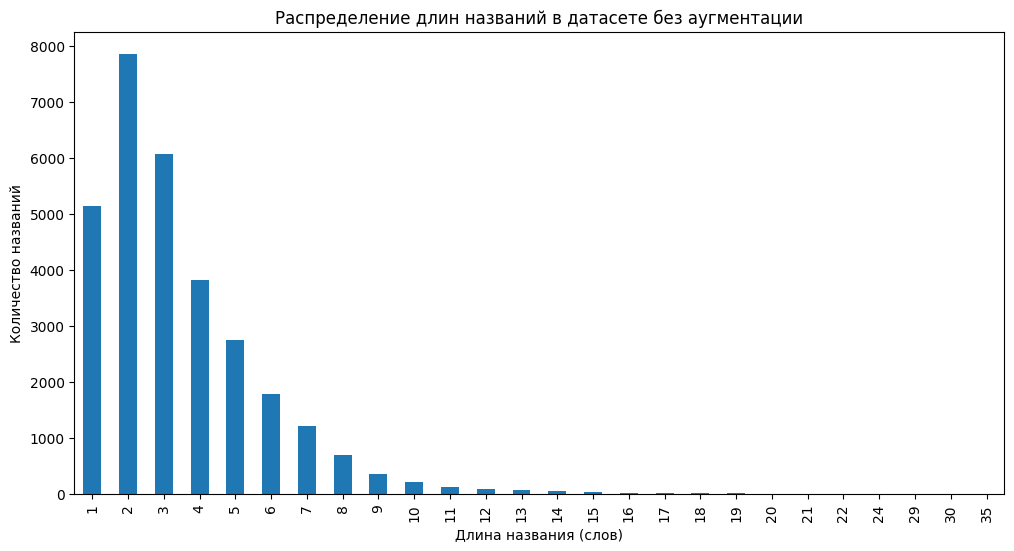

In [208]:
data["title_len"] = data.title.apply(lambda x: len(str(x).split()))

length_counts = data.groupby('title_len').size()

plt.figure(figsize=(12,6))
length_counts.plot(kind='bar')
plt.xlabel("Длина названия (слов)")
plt.ylabel("Количество названий")
plt.title("Распределение длин названий в датасете без аугментации")
plt.show()

Заметно, что есть названия с большим количеством слов. Это внесет в модель шум, поэтому стоит удалить их.

In [209]:
data.describe(include="O")

,text,title
count,30351,30351
unique,30351,27502
top,протопоп аввакум написал житие по благословени...,классика зарубежного рассказа
freq,1,26


In [210]:
data = data[data.title_len <= 10].reset_index(drop=True)

In [211]:
data.describe(include="O")

,text,title
count,29899,29899
unique,29899,27052
top,протопоп аввакум написал житие по благословени...,классика зарубежного рассказа
freq,1,26


In [212]:
data['text_len'] = data.text.str.split().apply(len)

In [213]:
print("Всего примеров:", len(data))
print("Уникальные заголовки:", data.title.nunique())
print("Средняя длина текста:", data.text_len.mean())
print("Средняя длина заголовка:", data.title_len.mean())

Всего примеров: 29899
Уникальные заголовки: 27052
Средняя длина текста: 1946.3624535937656
Средняя длина заголовка: 3.2834542961303055


In [214]:
data.head()

,text,title,title_len,text_len
0,протопоп аввакум написал житие по благословени...,"житие протопопа аввакума, им самим написанное",6,2054
1,князь андрей курбский один из лучших воевод ца...,переписка андрея курбского с иваном грозным,6,1359
2,"преподобный сергий родился в тверской земле, в...",житие сергия радонежского,3,2056
3,в городе муроме правил князь павел. к его жене...,повесть о петре и февронии муромских,6,852
4,"моление , как и многие другие произведения дре...",моление даниила заточника,3,223


In [215]:
data.drop(columns=["title_len", "text_len"], inplace=True)

In [216]:
data.to_csv("../data/all_data.csv", index=False)

# Посмотрим на облако слов

In [217]:
all_titles = " ".join(data.title.astype(str))

wordcloud = WordCloud(
    width=1200, height=600,
    background_color="white",
    max_words=400,
    colormap="viridis",
    collocations=False,
).generate(all_titles)

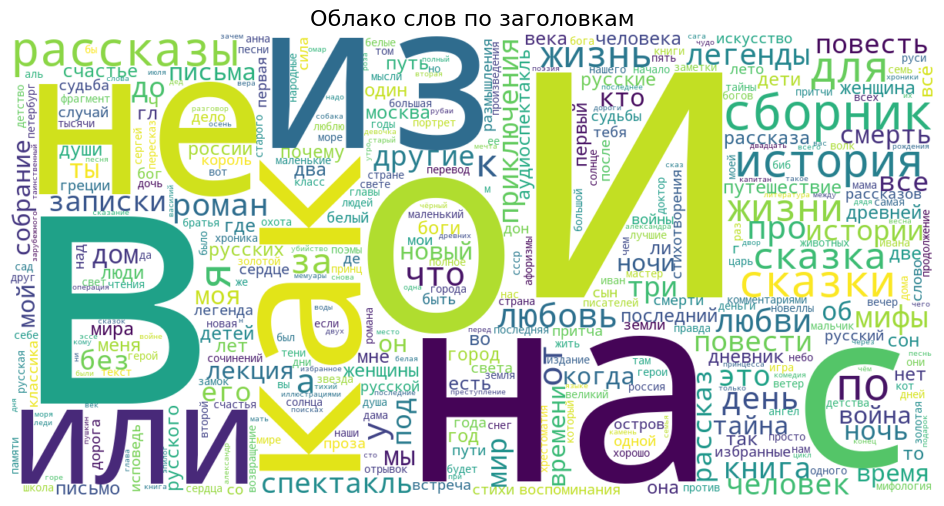

In [218]:
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Облако слов по заголовкам", fontsize=16)
plt.show()

Заметно, что самые популярные слова — предлоги, союзы и т.п., что логично. Их можно убрать, но оставим, чтобы модель училась генерировать названия, приближенные к реальности.